In [5]:
for x in range(2,4):
    print(x)

2
3


In [6]:
import os
import numpy as np
file_path = os.path.join('../../runs', 'debug_epoch1.npz')
file = np.load(file_path)
images = file['images']
targets = file['targets']
outputs = file['outputs']
reflectance_maps = file['reflectance_maps']
meta = file['meta']


Error showing sample 0: Invalid shape (1, 512, 512) for image data
meta for sample 0 [[   0.   25.    0.   55. 3000.]
 [  90.   25.  270.   55. 3000.]
 [ 180.   25.   90.   55. 3000.]
 [ 270.   25.  180.   55. 3000.]
 [   0.   25.  180.   90. 3000.]]
Error showing sample 1: Invalid shape (1, 512, 512) for image data
meta for sample 1 [[  90.   25.  270.   55. 3000.]
 [ 180.   25.   90.   55. 3000.]
 [ 270.   25.  180.   55. 3000.]
 [   0.   25.  180.   90. 3000.]
 [   0.   25.    0.   55. 3000.]]
Error showing sample 2: Invalid shape (1, 512, 512) for image data
meta for sample 2 [[ 180.   25.   90.   55. 3000.]
 [ 270.   25.  180.   55. 3000.]
 [   0.   25.  180.   90. 3000.]
 [   0.   25.    0.   55. 3000.]
 [  90.   25.  270.   55. 3000.]]
Error showing sample 3: Invalid shape (1, 512, 512) for image data
meta for sample 3 [[   0.   25.    0.   55. 3000.]
 [  90.   25.  270.   55. 3000.]
 [ 180.   25.   90.   55. 3000.]
 [ 270.   25.  180.   55. 3000.]
 [   0.   25.  180.   90. 3000

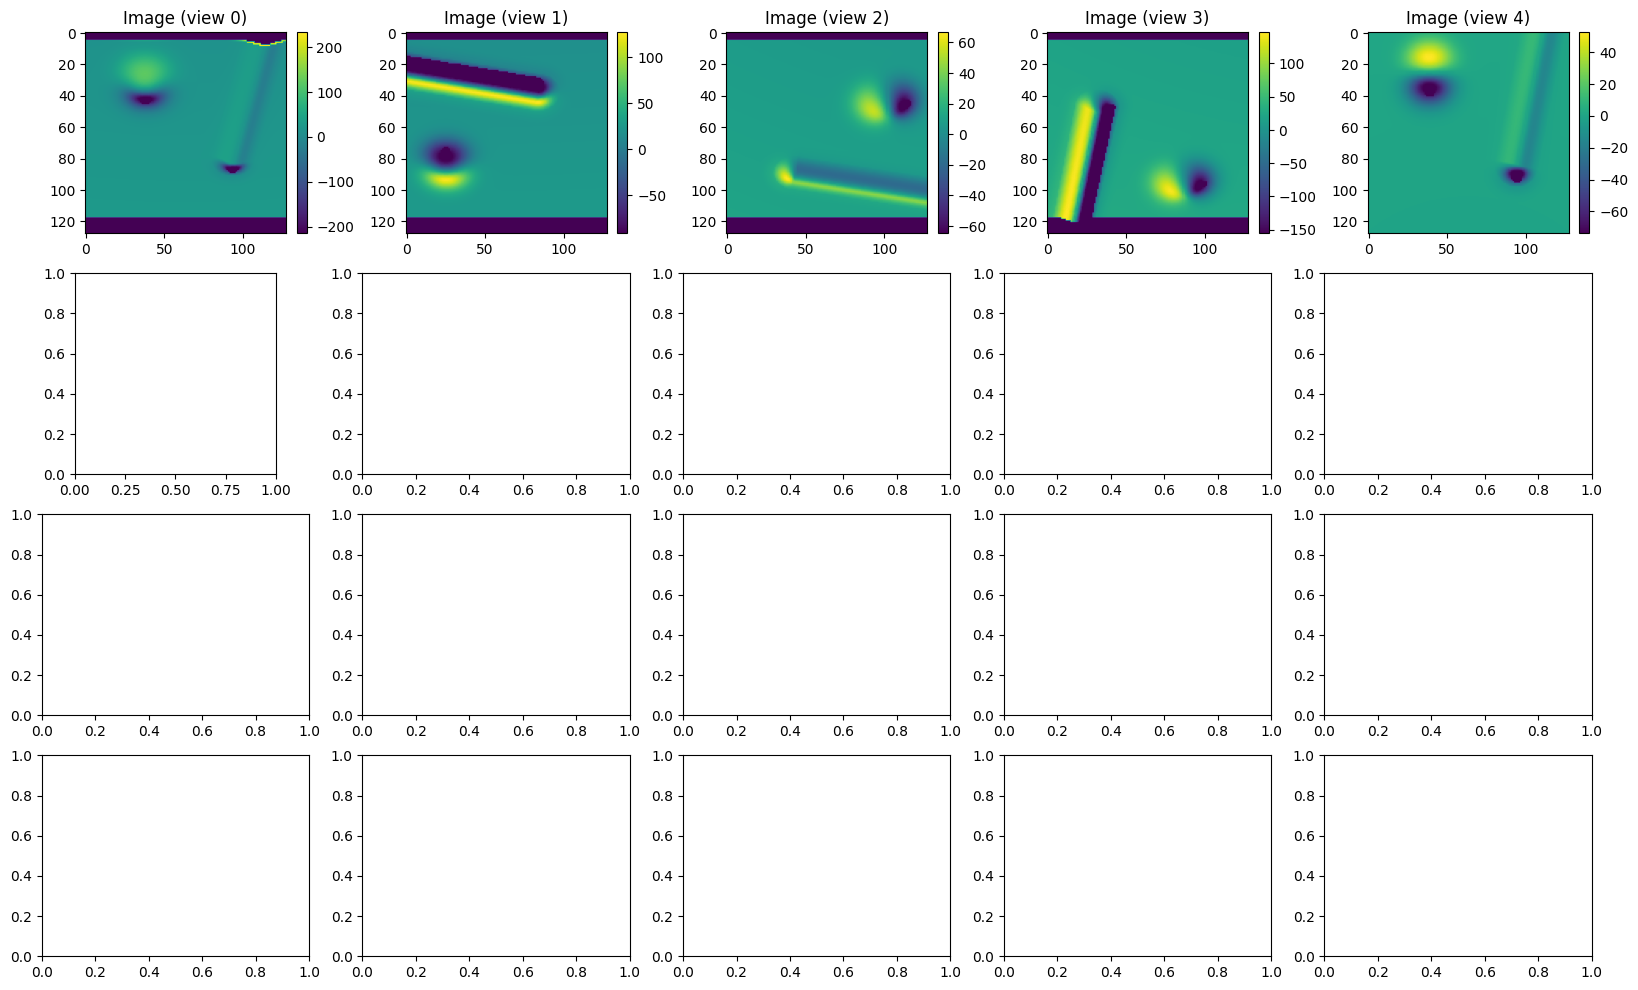

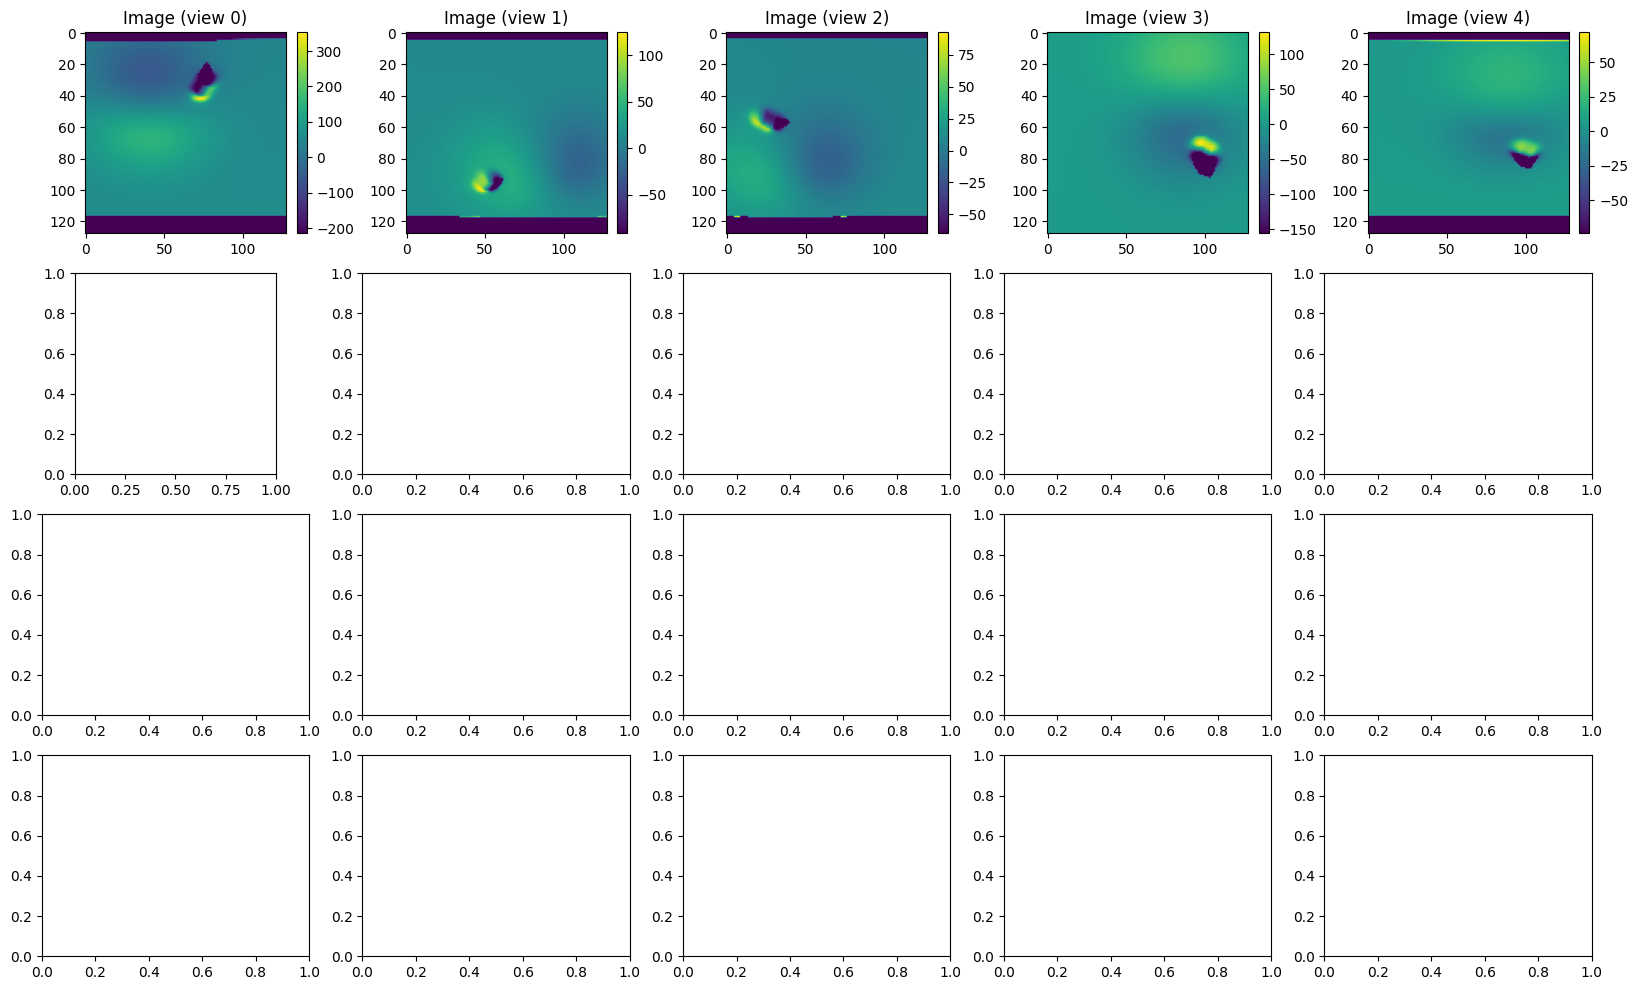

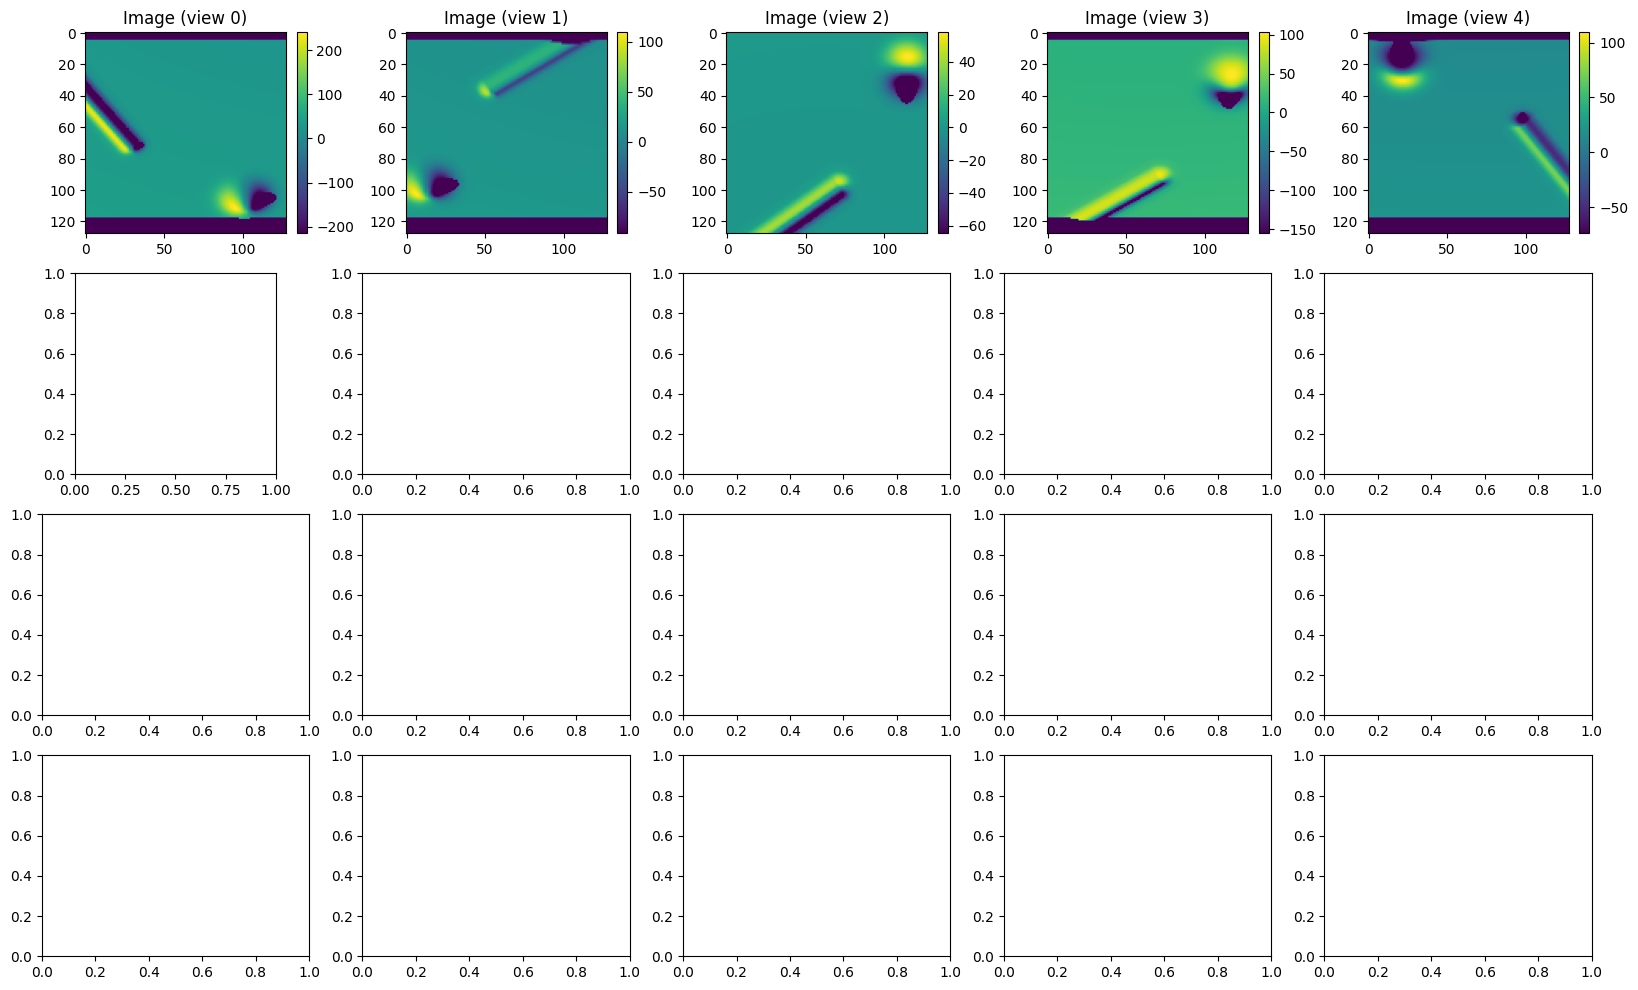

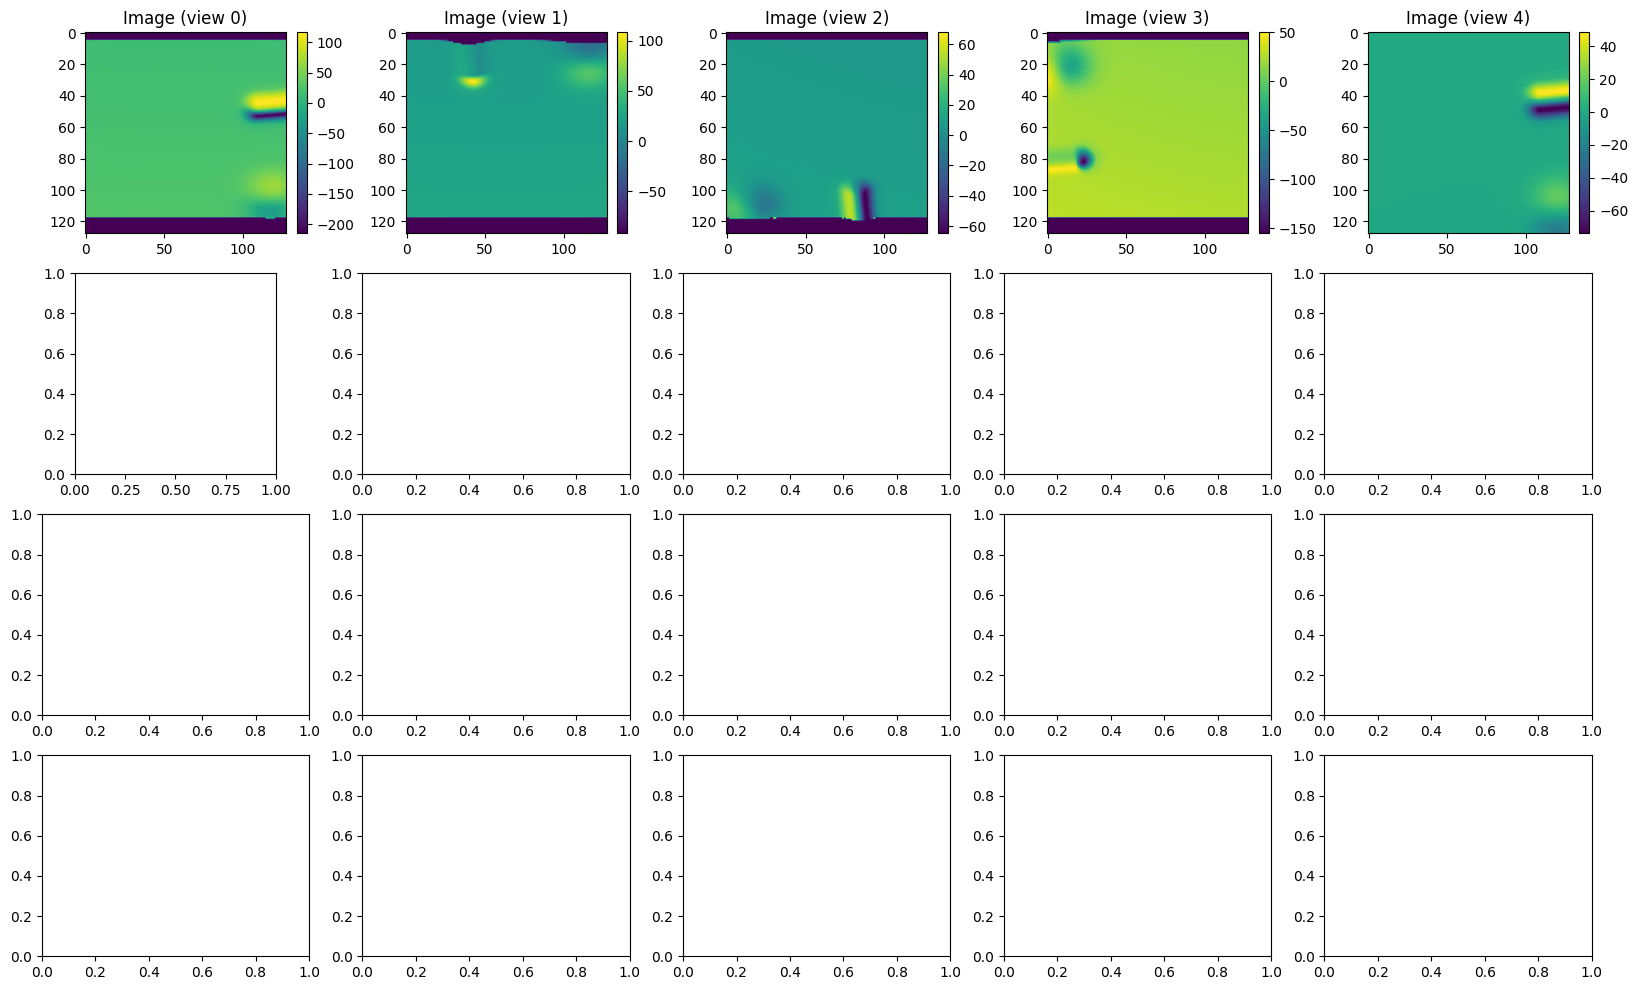

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def _is_color_image(arr):
    return isinstance(arr, np.ndarray) and arr.ndim == 3 and (arr.shape[-1] in (3, 4) or arr.shape[0] in (3, 4))

def _prepare_for_display(arr):
    "Prepare an array for imshow."
    if not isinstance(arr, np.ndarray):
        return arr, False
    # Squeeze singleton channel dimensions like (1,H,W) or (H,W,1)
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = arr[..., 0]
    # If channels-first (3,H,W) convert to (H,W,3)
    if arr.ndim == 3 and arr.shape[0] in (3, 4):
        arr = np.transpose(arr, (1, 2, 0))
        return arr, True
    # If channels-last color image
    if arr.ndim == 3 and arr.shape[-1] in (3, 4):
        return arr, True
    # At this point arr is likely 2D (H,W) or unexpected shape
    return arr, False

# Display a sample: rows = items (Image/Target/Output/Reflectance), columns = views (if stacked)
def show_sample(i, cmap='viridis'):
    items = [
        ('Image', images[i]),
        ('Target', targets[i]),
        ('Output', outputs[i]),
        ('Reflectance', reflectance_maps[i])
    ]
    # Determine number of columns (max views among items). If an item is a stack (k, H, W), use k; otherwise 1.
    ks = []
    for _, arr in items:
        if isinstance(arr, np.ndarray):
            if _is_color_image(arr):
                ks.append(1)
            elif arr.ndim == 3:
                ks.append(arr.shape[0])
            else:
                ks.append(1)
        else:
            ks.append(1)
    ncols = max(ks)
    nrows = len(items)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    # Normalize axes shape to 2D list
    if nrows == 1 and ncols == 1:
        axes = [[axes]]
    elif nrows == 1:
        axes = [list(axes)]
    elif ncols == 1:
        axes = [[ax] for ax in axes]
    else:
        axes = [list(row) for row in axes]

    for r, (title, arr) in enumerate(items):
        k = ks[r]
        for c in range(ncols):
            ax = axes[r][c]
            if arr is None:
                ax.text(0.5, 0.5, 'None', ha='center', va='center')
                ax.set_title(title if c == 0 else '')
                ax.axis('off')
                continue
            if k == 1:
                # single image (possibly color)
                if _is_color_image(arr):
                    if arr.shape[0] in (3,4):
                        img = np.transpose(arr, (1,2,0))
                    else:
                        img = arr
                    ax.imshow(img)
                else:
                    im = ax.imshow(arr, cmap=cmap)
                    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(title if c == 0 else '')
                ax.axis('off')
            else:
                # stacked views: arr expected shape (k, H, W) or (k, H, W, C)
                if c < k:
                    view = arr[c] if arr.ndim == 3 else arr[c]
                    if isinstance(view, np.ndarray) and view.ndim == 2:
                        im = ax.imshow(view, cmap=cmap)
                        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                    elif isinstance(view, np.ndarray) and view.ndim == 3:
                        # color view (H,W,3) or channels-first already handled above
                        ax.imshow(view)
                    else:
                        ax.text(0.5, 0.5, str(view), ha='center', va='center')
                else:
                    ax.axis('off')
                ax.set_title(f'{title} (view {c})')
    fig.suptitle(f'Sample {i}')
    plt.tight_layout()
    plt.show()

# Show a few samples (up to 6)
num = min(6, int(images.shape[0])) if hasattr(images, 'shape') else min(6, len(images))
for i in range(num):
    try:
        show_sample(i)
    except Exception as e:
        print(f'Error showing sample {i}:', e)
    # Print metadata for this sample if available
    try:
        print('meta for sample', i, meta[i])
    except Exception:
        print('meta:', meta)